In [1]:
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter('ignore')


## 参考ノート
https://www.kaggle.com/code/dronqo/how-successful-is-your-kickstarter-project/notebook

In [2]:
# データの読み込み
df_org = pd.read_csv('./data/ks-projects-201801.csv')


In [3]:
# # 成功（successful）と失敗（failed）以外のデータを除外する
# df = df_org[(df_org['state'] == 'successful') | (df_org['state'] == 'failed')]

In [4]:
df = df_org

In [5]:
print('Dimension of the dataset:', df.shape)

Dimension of the dataset: (378661, 15)


In [6]:
# name of the columns
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [7]:
# data type of each column
df.dtypes.value_counts()

object     8
float64    5
int64      2
dtype: int64

In [8]:
# number of missing values per column
df.isnull().sum().sort_values(ascending = False)

usd pledged         3797
name                   4
ID                     0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [9]:
# remove rows with missing values
df.dropna(inplace=True)


In [10]:
# number of unique values per column, sorted by descending order
df.T.apply(lambda x: x.nunique(), axis=1).sort_values(ascending=False)

ID                  374860
launched            374298
name                372068
usd_pledged_real    105383
usd pledged          95454
pledged              61936
usd_goal_real        50032
goal                  8312
backers               3963
deadline              3164
category               159
country                 22
main_category           15
currency                14
state                    5
dtype: int64

In [11]:
def categorical_with_per_count(kick, feature):
    '''
    Calculate frequency of the categorical feature with % and count base.
    Sorted on the descending order.
    '''
    
    # calculate frequency on % and value
    freq_merged = pd.concat([kick[feature].value_counts(normalize=True) * 100,
                             kick[feature].value_counts(normalize=False)], axis=1)
    # rename columns
    freq_merged.columns = [feature + '_%', feature + '_count']
    return freq_merged

In [12]:
# stateの水準
categorical_with_per_count(df, 'state')

,state_%,state_count
failed,52.715947,197611
successful,35.706931,133851
canceled,10.339060,38757
live,0.746412,2798
suspended,0.491650,1843


In [13]:
# keep `failed` and `successful` states
df.query("state in ['failed', 'successful']", inplace=True)

In [14]:
# class balance of the dataframe
categorical_with_per_count(df, 'state')

,state_%,state_count
failed,59.617995,197611
successful,40.382005,133851


In [15]:
# select features for further analysis
df = df.loc[:, ['name', 'category', 'main_category', 'deadline',
                    'usd_goal_real', 'launched', 'state', 'country']]
# currency can be explained by country i.e. Euro is used by European countries, 
# Pounds for Great Britain, Dollar in USA, etc.

In [16]:
# rename `usd_goal_real` to `goal`
df.rename(columns={'usd_goal_real':'goal'}, inplace=True)

## １変量解析（Univariate feature analysis）

### main category
下記の分析の通り、すべての水準にデータが分布している。そのため、特にグルーピング等は実施しない。

In [17]:
# frequency of the main category
categorical_with_per_count(df, 'main_category')

,main_category_%,main_category_count
Film & Video,17.046600,56503
Music,13.817874,45801
Publishing,10.683879,35413
Games,8.604305,28520
Technology,8.159608,27046
Art,7.735427,25640
Design,7.651858,25363
Food,6.653553,22054
Fashion,5.965691,19774
Theater,3.089947,10242


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot:xlabel='count', ylabel='main_category'>

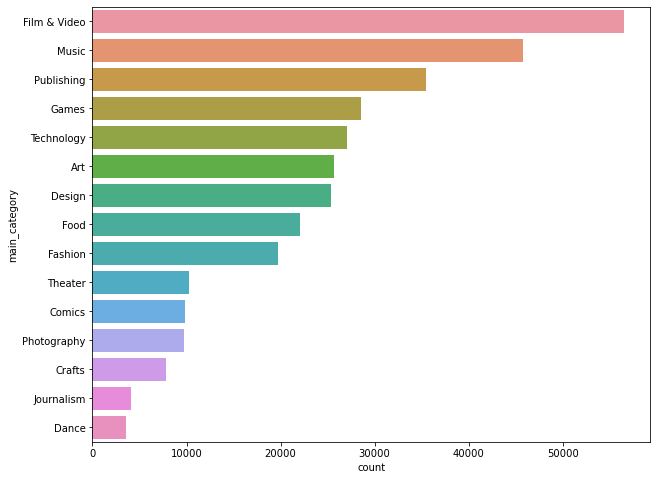

In [19]:
# change dimension of the plot
dims = (10, 8)
fig, ax = plt.subplots(figsize = dims)

# barplot of the main categories by descending order
sns.countplot(
    y=df.main_category,
    order = df['main_category'].value_counts().index
)

### country
下記の通り、78.8%がUSである。そのためUSAとOthersに分類する。

In [20]:
# top 10 the most frequent country
categorical_with_per_count(df, 'country').head(n=10)

,country_%,country_count
US,78.850064,261358
GB,8.885785,29453
CA,3.731951,12370
AU,1.996006,6616
DE,1.036620,3436
FR,0.760268,2520
NL,0.727384,2411
IT,0.714712,2369
ES,0.565072,1873
SE,0.455256,1509


### Goal（目標金額）
- 下記のように75%とmaxの間が大きいため、小さい額に偏っている。
- 分割数を10とした度数分布を見ると、プロジェクトで最も人気のある金額は5Kまたは10Kであることがわかる。
- それ以外の場合、プロジェクトは1000、500で割り切れる。
- 対数変換する

In [21]:
df.goal.describe()


count    3.314620e+05
mean     4.152286e+04
std      1.109279e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: goal, dtype: float64

In [22]:
# calculate frequency of the goal: the most popular goal
categorical_with_per_count(df, 'goal').head(n=10)


,goal_%,goal_count
5000.0,6.464693,21428
10000.0,5.536381,18351
1000.0,3.592569,11908
3000.0,3.458315,11463
2000.0,3.258292,10800
15000.0,3.025385,10028
2500.0,2.685376,8901
20000.0,2.655810,8803
500.0,2.393940,7935
1500.0,2.233439,7403


<AxesSubplot:xlabel='goal', ylabel='Density'>

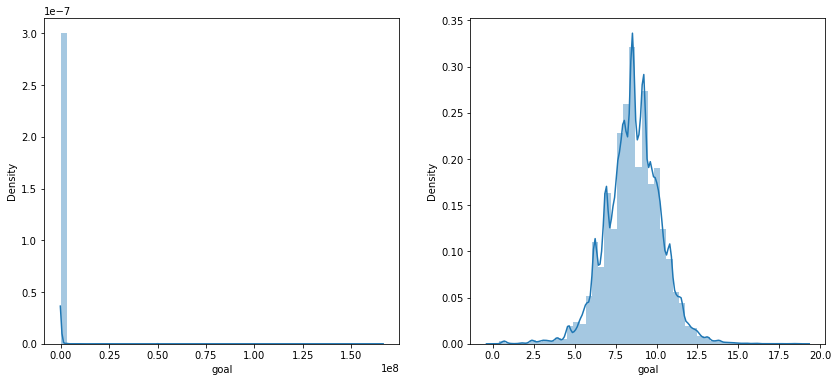

In [23]:
# combine different plots into one: goal and log(goal)
dims = (14, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=dims)
sns.distplot(df.goal, ax=ax1)
sns.distplot(np.log1p(df.goal), ax=ax2)

### Launched and deadline

In [24]:
# convert strings to `datetime`
df['launched'] = pd.to_datetime(df.launched)
df['deadline'] = pd.to_datetime(df.deadline)
df = df.sort_values('launched')

### WordCloud
省略

## 特徴量生成

### プロジェクト名

In [25]:
# initialize new data frame
kk = pd.DataFrame()

In [26]:
# length of the name
kk['name_len'] = df.name.str.len()

In [27]:
# if name contains a question mark
kk['name_is_question'] = (df.name.str[-1] == '?').astype(int)


In [28]:
# if name contains an exclamation mark
kk['name_is_exclamation'] = (df.name.str[-1] == '!').astype(int)


In [29]:
# if name is uppercase
kk['name_is_upper'] = df.name.str.isupper().astype(float)


In [30]:
def count_non_character(row):
    '''Number of non character in the sentence'''
    return sum((0 if c.isalpha() else 1 for c in str(row)))


In [31]:
# number of non character in the name
kk['name_non_character'] = df.name.apply(count_non_character)


In [32]:
# number of words in the name
kk['name_number_of_word'] = df.name.apply(lambda x: len(str(x).split(' ')))


In [33]:
# We generate new feature based on ratio between vowels and other alpha characters
def countVowelstoLettersRatio(s):
    '''Count ratio between vowels and letters'''
    s = str(s)
    count = 1  
    vowels = 0
    for i in s:
        if i.isalpha():
            count = count + 1
            if i in 'aeiou':
                vowels = vowels + 1
    return ((vowels * 1.0) / count)

In [34]:
# for each name calculate vowels ratio
kk['name_vowel_ratio'] = df.name.apply(countVowelstoLettersRatio)


### country


In [35]:
# create indicator variable for `country` variable
kk['country_is_us'] = (df.country == 'US').astype(int)


### Goal


In [36]:
kk['Goal_1000'] = df.goal.apply(lambda x: x // 1000)
kk['Goal_500'] = df.goal.apply(lambda x: x // 500)
kk['Goal_10'] = df.goal.apply(lambda x: x // 10)


In [37]:
# log transformation of `goal` to reduce skewness 
# df['goal'] = np.log1p(df.goal)
kk['goal'] = np.log1p(df.goal)


### 過去のプロジェクト数


In [38]:
from datetime import datetime
import time

def get_timestamp(dt):
    '''Add timestamp as a value'''
    return time.mktime(dt.timetuple())


In [39]:
df['timestamp'] = df['launched'].apply(get_timestamp)    


In [40]:
# We will create data frames containing only single main category
categories = set(df.main_category)
frames = {}
for ct in categories:
    frames[ct] = df[df['main_category'] == ct]


In [43]:
!pip install pyprind

In [44]:
# We will use Progressbar to track progress as it istime consuming operation
import pyprind

def getElementsInRange(cat,end,week):
    '''Get number of launched projects in given range from (end - week) to end'''
    global pbar
    pob = frames[cat]
    start = end - pd.DateOffset(weeks = week)
    # as we sorted our projects by launch date earlier geting number of projects in given date range is easy
    # value = pob['launched'].searchsorted(end)[0] - pob['launched'].searchsorted(start)[0]
    value = pob['launched'].searchsorted(end) - pob['launched'].searchsorted(start)
    pbar.update()
    return value

In [45]:
pbar = pyprind.ProgBar(331675)
# Number of projects in same category for last week    
kk['Last_Week'] = df.apply(lambda x: getElementsInRange(x['main_category'],x['launched'],1),axis = 1) 

In [46]:
pbar = pyprind.ProgBar(331675)
# Number of projects in same category for last month    
kk['Last_Month'] = df.apply(lambda x: getElementsInRange(x['main_category'],x['launched'],4),axis = 1) 


In [47]:
kk['Last_Week']

169268    0
322000    0
138572    0
325391    0
122662    1
         ..
329616    1
43850     2
80946     0
111813    3
339929    0
Name: Last_Week, Length: 331462, dtype: int64

In [48]:
pbar = pyprind.ProgBar(331675)
# Number of projects in same category for last 6 months  
kk['Last_6_Month'] = df.apply(lambda x: getElementsInRange(x['main_category'],x['launched'],26),axis = 1)


In [49]:
pbar = pyprind.ProgBar(331675)
# Number of projects in same category for last 3 months  
kk['Last_3_Month'] = df.apply(lambda x: getElementsInRange(x['main_category'],x['launched'],13),axis = 1)


In [50]:
pbar = pyprind.ProgBar(331675)
# Number of projects in same category for last year    
kk['Last_Year'] = df.apply(lambda x: getElementsInRange(x['main_category'],x['launched'],52),axis = 1) 


In [51]:
kk.head()

,name_len,name_is_question,name_is_exclamation,name_is_upper,name_non_character,name_number_of_word,name_vowel_ratio,country_is_us,Goal_1000,Goal_500,Goal_10,goal,Last_Week,Last_Month,Last_6_Month,Last_3_Month,Last_Year
169268,59,0,0,0.0,16,11,0.363636,1,1.0,2.0,100.0,6.908755,0,0,0,0,0
322000,30,0,0,1.0,3,4,0.000000,1,80.0,160.0,8000.0,11.289794,0,0,0,0,0
138572,19,0,0,0.0,2,3,0.277778,1,0.0,0.0,2.0,3.044522,0,0,0,0,0
325391,28,0,0,0.0,3,4,0.423077,1,0.0,0.0,9.0,4.605170,0,0,0,0,0
122662,10,0,0,0.0,0,1,0.181818,1,1.0,3.0,190.0,7.550135,1,1,1,1,1


In [52]:
def getDelta(a,b):
    '''Get diffence in days between launch and deadline'''
    return (a - b).days


In [53]:
# Duration of the project   
kk['Duration'] = df.apply(lambda x: getDelta(x['deadline'],x['launched']),axis = 1)


In [54]:
## Month of launch
kk['Month'] = df['launched'].apply(lambda x : x.month)


In [55]:
## Month of deadline
kk['deadline_month'] = df['deadline'].apply(lambda x : x.month)


In [56]:
# indicator feature for weekend（launched dayが平日か否か）
kk['isLaunchWeekend'] = df['launched'].apply(lambda x : int(x.weekday() > 5))


In [57]:
kk['Category'] = df['category']
kk['main_category'] = df['main_category']


### Mean and median values of goals in date ranges

In [58]:
def getRangeMean(cat,end,week):
    global pbar
    pob = frames[cat]
    start = end - pd.DateOffset(weeks = week)
    # value = pob.iloc[pob['launced'].searchsorted(start)[0]:pob['launced'].searchsorted(end)[0]]['goal'].mean()
    value = pob.iloc[pob['launched'].searchsorted(start):pob['launched'].searchsorted(end)]['goal'].mean()
    pbar.update()
    return value


In [59]:
pbar = pyprind.ProgBar(331675)
# Mean goal for category last month
kk['mean_goal_in_category_last_month'] = df.apply(lambda x: getRangeMean(x['main_category'],x['launched'],4),axis = 1) 

In [60]:
def getRangeMedian(cat,end,week):
    global pbar
    pob = frames[cat]
    start = end - pd.DateOffset(weeks = week)
    # value = pob.iloc[pob['launced'].searchsorted(start)[0]:pob['launced'].searchsorted(end)[0]]['goal'].median()
    value = pob.iloc[pob['launched'].searchsorted(start):pob['launched'].searchsorted(end)]['goal'].median()
    pbar.update()
    return value


In [61]:
pbar = pyprind.ProgBar(331675)
# Median goal for category last month
kk['median_goal_in_category_last_month'] = df.apply(lambda x: getRangeMedian(x['main_category'],x['launched'],4),axis = 1) 


In [62]:
pbar = pyprind.ProgBar(331675)
# Mean goal for category last month
kk['mean_goal_in_category_last_year'] = df.apply(lambda x: getRangeMean(x['main_category'],x['launched'],52),axis = 1) 


In [63]:
kk['median_goal_Last_6_Month'] = df.apply(lambda x: getRangeMedian(x['main_category'],x['launched'],26),axis = 1)

In [64]:
kk['mean_goal_Last_6_Month'] = df.apply(lambda x: getRangeMean(x['main_category'],x['launched'],26),axis = 1)


In [65]:
kk['mean_goal_Last_Week'] = df.apply(lambda x: getRangeMean(x['main_category'],x['launched'],1),axis = 1)


In [66]:
kk['median_goal_Last_Week'] = df.apply(lambda x: getRangeMedian(x['main_category'],x['launched'],1),axis = 1)


In [67]:
kk = kk.fillna(0)   # fill created NAs with 0s

In [68]:
# include state of project
kk['state'] = df.state


## Visualization
略
- Durationが長いほどfailed率が高くなる
- カテゴリ”Chiptune”は80%以上の成功率を誇る
- Apps/Web/Mobile Gamesは成功率が最も低い
- name_vowel_ratio（プロジェクト名に占める母音率）が大きいほどfailedが多くなる

## Partition dataset into train / test sets

In [69]:
# seperate dependent and independent part into seperate variables
y = (kk.state == 'successful').astype(int)
x = kk.drop(['state'], axis = 1)

In [70]:
# y.head()

In [71]:
from sklearn.preprocessing import LabelEncoder
# transform target variable into categorical value
class_le = LabelEncoder()
y = class_le.fit_transform(y.values)

In [72]:
y

array([0, 0, 1, ..., 1, 1, 1])

### Principal Component Analysis - PCA
- main category（１５種）とcategory（１５９種）をOne-Hotエンコーディングすると174個の変数ができてしまう
- PCAを行い、ディメンションを下げる

In [73]:
# create dummy variable for main category and category variables
x_pca = pd.get_dummies(x, columns = ['Category','main_category'], drop_first=True)


In [74]:
# x_pca.isnull().sum().to_list()

In [75]:
x_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 169268 to 339929
Columns: 200 entries, name_len to main_category_Theater
dtypes: float64(13), int64(15), uint8(172)
memory usage: 127.7 MB


In [76]:
from sklearn.decomposition import PCA
# explained variance ratio with cumulative sum
pca = PCA(n_components=10, random_state=1)
X_pca = pca.fit_transform(x_pca.values)

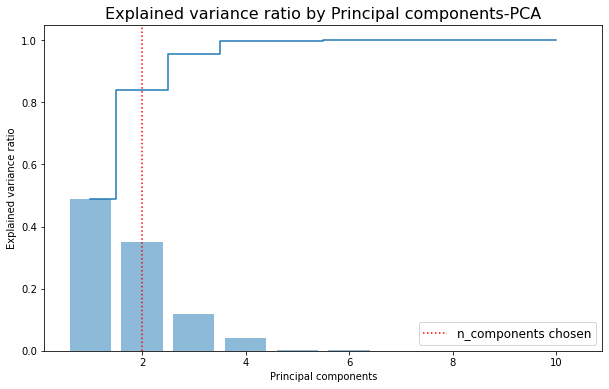

In [77]:
# plot cumulative variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.title('Explained variance ratio by Principal components-PCA', fontsize=16)
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.axvline(2, linestyle=':', label='n_components chosen', c='red')
plt.legend(prop=dict(size=12))

plt.show()


上記のグラフの説明は下記の通り。
- ヒストグラム：各コンポーネントの分散説明率
- 青線：分散説明率の蓄積
- 赤線：コンポーネントの最適な数

グラフの結果は、４個の主成分でデータが説明できるということを示している。

※分散説明率：主に単回帰分析／重回帰分析といった線形回帰（Linear Regression）*1における回帰式のモデルなどが、「観測データ（正解データ、従属変数、目的変数）*2の分散（＝データの広がり具合）のうちどれくらいを説明するか」という割合（通常は0～1.0＝100％、マイナスになることもある）
https://atmarkit.itmedia.co.jp/ait/articles/2110/21/news019.html

## クラスの変動性の可視化
最初の２個のコンポーネントによるプロジェクトの成功・失敗を示す。
X軸は第一成分、Y軸は第二成分。
それぞれのクラスに大きな分散があることがわかる。

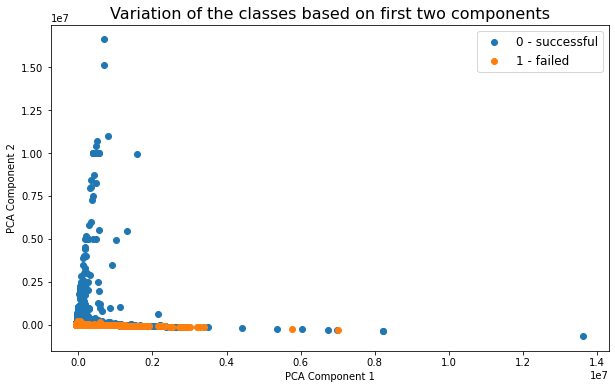

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='0 - successful')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='1 - failed')

plt.title('Variation of the classes based on first two components', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best', prop=dict(size=12))

plt.show()


## モデリングとハイパーパラメータ最適化

In [79]:
# perform One-hot-encoding
x = pd.get_dummies(x, columns = ['main_category','Category'], drop_first=True)


In [80]:
from sklearn.model_selection import StratifiedShuffleSplit
# initialize balanced class indeces
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# initialize values into different variables
for train_index, test_index in sss.split(x, y):
    X_train, X_test = x.iloc[train_index, :].reset_index(drop=True), x.iloc[test_index, :].reset_index(drop=True)
    y_train, y_test = y[train_index], y[test_index]


In [81]:
print('Train dataset class distribution:')
print(np.bincount(y_train))

print('\nTest dataset class distribution:')
print(np.bincount(y_test))


Train dataset class distribution:
[158088 107081]

Test dataset class distribution:
[39523 26770]


### KNNの場合の最適化

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
pipe_knn = Pipeline(steps=[
    ('scl', StandardScaler()), # scale the matrix
    ('pca', PCA(n_components=2, random_state=1)), # reduce the dimensionality
    ('knn', KNeighborsClassifier(n_neighbors=4, p=2, metric='minkowski', n_jobs=-1)) # perform KNN
])


In [83]:
param_grid = [
    {
        'pca__n_components': [3, 5, 7],
        'knn__n_neighbors': [3, 4, 5]
    }
]


In [84]:
from sklearn.model_selection import GridSearchCV
estimator = GridSearchCV(
        pipe_knn,
        cv=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=1), # preserve class balance
        param_grid=param_grid,
        scoring='roc_auc',
        n_jobs=-1
    )


### Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
# initialize list of the transformations
pipe_rf = Pipeline(steps=[
    ('std', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=3))
])

# list of the parameters to test
param_grid = [
    {
        'rf__max_depth': [3, 4, 5],
        'rf__min_samples_leaf': [4, 5]
    }
]

# initialize grid search
estimator = GridSearchCV(
    pipe_rf,
    cv=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=1), # preserve class balance
    param_grid=param_grid,
    scoring='roc_auc'
)

# fit train data
estimator.fit(X_train, y_train)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=1, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=4,
                                                               min_samples_leaf=3))]),
             param_grid=[{'rf__max_depth': [3, 4, 5],
                          'rf__min_samples_leaf': [4, 5]}],
             scoring='roc_auc')

In [86]:
print('Best Grid Search result :', estimator.best_score_)
print('Best parameter :', estimator.best_params_)

Best Grid Search result : 0.6935187655957931
Best parameter : {'rf__max_depth': 5, 'rf__min_samples_leaf': 4}


In [87]:
# get best classifier
clf_rf = estimator.best_estimator_

# predict test data set
y_pred_rf = estimator.predict(X_test)

In [88]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# test data set auc error
print('Train data ROC/AUC :', )
print('Test data ROC/AUC :', roc_auc_score(y_true=y_test, y_score=y_pred_rf))

# confusion matrix
print('\nConfusion matrix')
print(confusion_matrix(y_true=y_test, y_pred=y_pred_rf))

# classification matrix
print('\nClassification matrix')
print(classification_report(y_true=y_test, y_pred=y_pred_rf))


Train data ROC/AUC :
Test data ROC/AUC : 0.5789862285755392

Confusion matrix
[[36514  3009]
 [20503  6267]]

Classification matrix
              precision    recall  f1-score   support

           0       0.64      0.92      0.76     39523
           1       0.68      0.23      0.35     26770

    accuracy                           0.65     66293
   macro avg       0.66      0.58      0.55     66293
weighted avg       0.65      0.65      0.59     66293



### ロジスティック回帰

In [89]:
from sklearn.linear_model import LogisticRegression
# initialize list of the transformations
pipe_lr = Pipeline(steps=[
    ('std', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', C=0.001, random_state=0))
])

param_grid = [
    {
        'lr__C': [0.001, 0.01, 0.1, 1],
        'lr__penalty': ['l1', 'l2']  # regularizatian parameter
    }
]

estimator = GridSearchCV(
    pipe_lr,
    cv=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=1), # preserve class balance
    param_grid=param_grid,
    scoring='roc_auc',
)

# fit training data
estimator.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=1, test_size=0.3,
            train_size=None),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(C=0.001,
                                                           penalty='l1',
                                                           random_state=0))]),
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1],
                          'lr__penalty': ['l1', 'l2']}],
             scoring='roc_auc')

In [90]:
print('Best Grid Search result :', estimator.best_score_)
print('Best parameter :', estimator.best_params_)


Best Grid Search result : 0.7315360049795306
Best parameter : {'lr__C': 1, 'lr__penalty': 'l2'}


In [91]:
# get best estimator
clf_lr = estimator.best_estimator_

# predict test data set
y_pred_lr = estimator.predict(X_test)


In [92]:
# test data set auc error
print('Train data ROC/AUC :', )
print('Test data ROC/AUC :', roc_auc_score(y_true=y_test, y_score=y_pred_lr))

# confusion matrix
print('\nConfusion matrix')
print(confusion_matrix(y_true=y_test, y_pred=y_pred_lr))

# classification matrix
print('\nClassification matrix')
print(classification_report(y_true=y_test, y_pred=y_pred_lr))


Train data ROC/AUC :
Test data ROC/AUC : 0.6512543194516537

Confusion matrix
[[31533  7990]
 [13260 13510]]

Classification matrix
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     39523
           1       0.63      0.50      0.56     26770

    accuracy                           0.68     66293
   macro avg       0.67      0.65      0.65     66293
weighted avg       0.67      0.68      0.67     66293



### Light GBM

In [95]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:0000:010:01


In [96]:
import lightgbm as lgb
# initialize list of the transformations

# We will use parameters that were found based on experiments made on local machine

clf_gbm = lgb.LGBMClassifier(
        n_estimators=1000,
        num_leaves=25,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=9,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
)


# fit training data
clf_gbm.fit(X_train,
              y_train,
              eval_metric='auc', 
              verbose=0)


LGBMClassifier(colsample_bytree=0.8, max_depth=9, min_split_gain=0.01,
               n_estimators=1000, num_leaves=25, reg_alpha=0.1, reg_lambda=0.1,
               subsample=0.9)

In [97]:
# predict test data set
y_pred_gbm = clf_gbm.predict(X_test)


In [98]:
# test data set auc error
print('Test data ROC/AUC :', roc_auc_score(y_true=y_test, y_score=y_pred_gbm))

# confusion matrix
print('\nConfusion matrix')
print(confusion_matrix(y_true=y_test, y_pred=y_pred_gbm))

# classification matrix
print('\nClassification matrix')
print(classification_report(y_true=y_test, y_pred=y_pred_gbm))


Test data ROC/AUC : 0.6765719943043996

Confusion matrix
[[31268  8255]
 [11725 15045]]

Classification matrix
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     39523
           1       0.65      0.56      0.60     26770

    accuracy                           0.70     66293
   macro avg       0.69      0.68      0.68     66293
weighted avg       0.69      0.70      0.69     66293



In [99]:
# feature importance for Light GBM
predictor_columns = X_train.columns
feat_import = list(zip(predictor_columns, list(clf_gbm.feature_importances_)))
ns_df = pd.DataFrame(data = feat_import, columns=['Feat_names', 'Importance'])
ns_df_sorted = ns_df.sort_values(['Importance', 'Feat_names'], ascending = [False, True])

ns_df_sorted


,Feat_names,Importance
6,name_vowel_ratio,1631
26,mean_goal_Last_Week,1425
17,Duration,1388
0,name_len,1302
12,Last_Week,1299
...,...,...
124,Category_Literary Spaces,0
133,Category_Musical,0
142,Category_Pet Fashion,0
159,Category_Quilts,0


In [100]:
ns_df_sorted.head(40)

,Feat_names,Importance
6,name_vowel_ratio,1631
26,mean_goal_Last_Week,1425
17,Duration,1388
0,name_len,1302
12,Last_Week,1299
21,mean_goal_in_category_last_month,1169
10,Goal_10,1166
27,median_goal_Last_Week,1057
13,Last_Month,980
23,mean_goal_in_category_last_year,810


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from collections import Counter
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
